## Imports

In [1]:
# import torch
# if torch.cuda.is_available():
#     num_gpu = torch.cuda.device_count()
#     print(f"Number of available GPUs: {num_gpu}")

#     # for i in range(num_gpu):
#     #     device = torch.device(f"cuda:{i}")
#     #     device_name = torch.cuda.get_device_name(i)
#     #     print(f"GPU {i}: {device_name}", device)
# else:
#     print("No GPUs available, using CPU.")

# device = torch.device('cuda:2')
# device

Number of available GPUs: 4


/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


device(type='cuda', index=2)

In [1]:
try:
    from astra.torch.models import ResNetClassifier
    print('installed')
except:
    print('not installed')
    pass
#     %pip install git+https://github.com/sustainability-lab/ASTRA

installed


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm

import umap

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier

# Netron, ONNX for model visualization
import netron
import onnx


/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jaiswalsuraj/suraj_work/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/jaiswalsuraj/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.cuda.get_device_name(device)

/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


(device(type='cuda'), 'NVIDIA A100-SXM4-80GB')

## Dataset

In [4]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

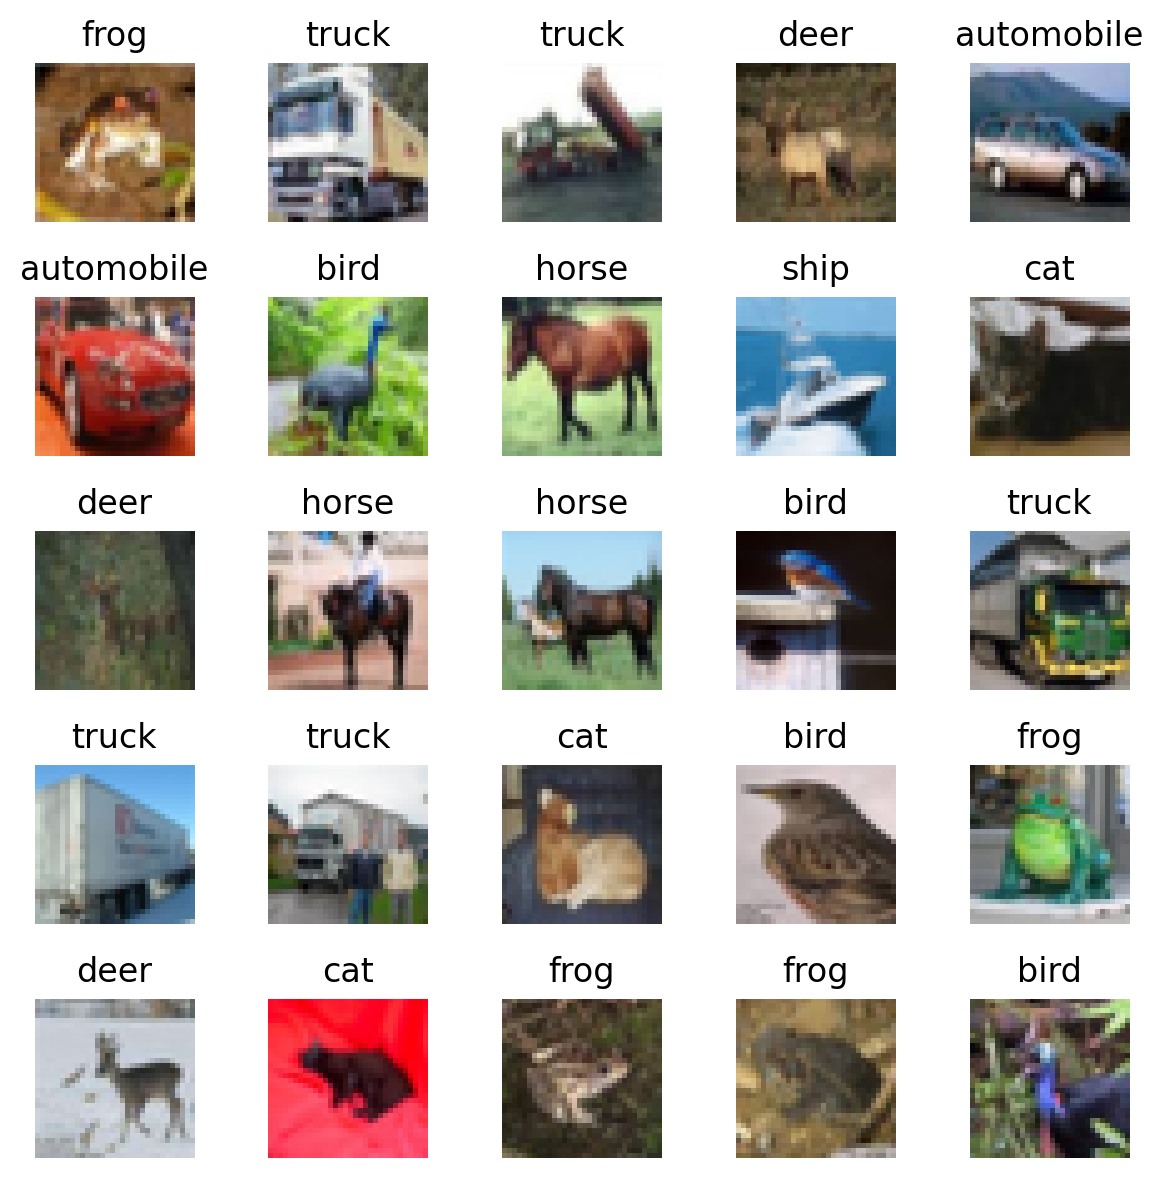

In [5]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()


## Train val test split

In [6]:
n_train = 1000
n_test = 20000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [7]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


In [8]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

In [9]:
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [10]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [11]:
# Export to ONNX and visualize with Netron
dummy_input = torch.randn(1, 3, 32, 32).to(device)
torch.onnx.export(resnet, dummy_input, "resnet.onnx", verbose=True)
netron.start("resnet.onnx")

Exported graph: graph(%input.1 : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cuda:0),
      %classifier.featurizer.input_layer.weight : Float(512, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %classifier.featurizer.input_layer.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %classifier.classifier.weight : Float(10, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %classifier.classifier.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::Conv_198 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_199 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_201 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_202 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_204 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
    

('localhost', 8080)

train set accuracy: 7.70%


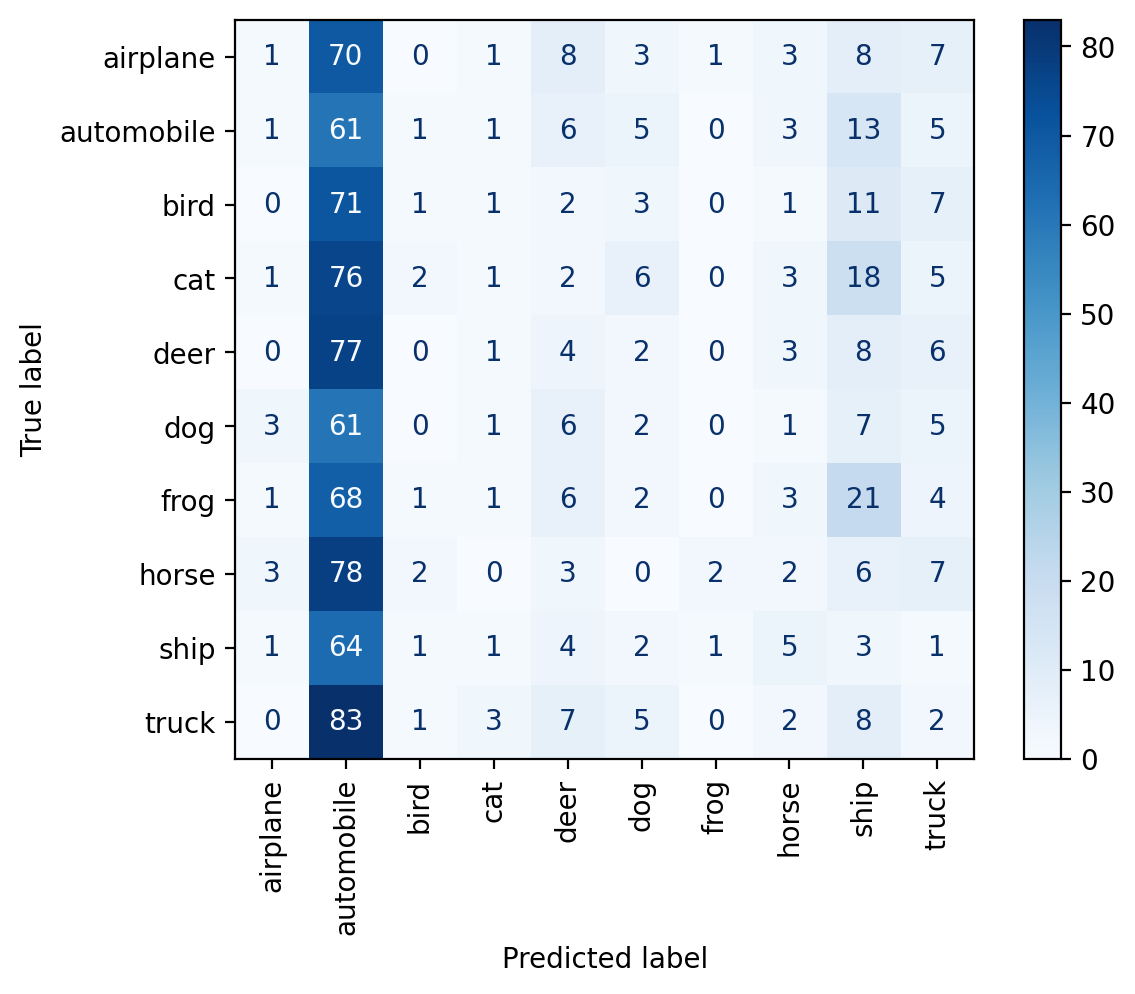

pool set accuracy: 8.37%


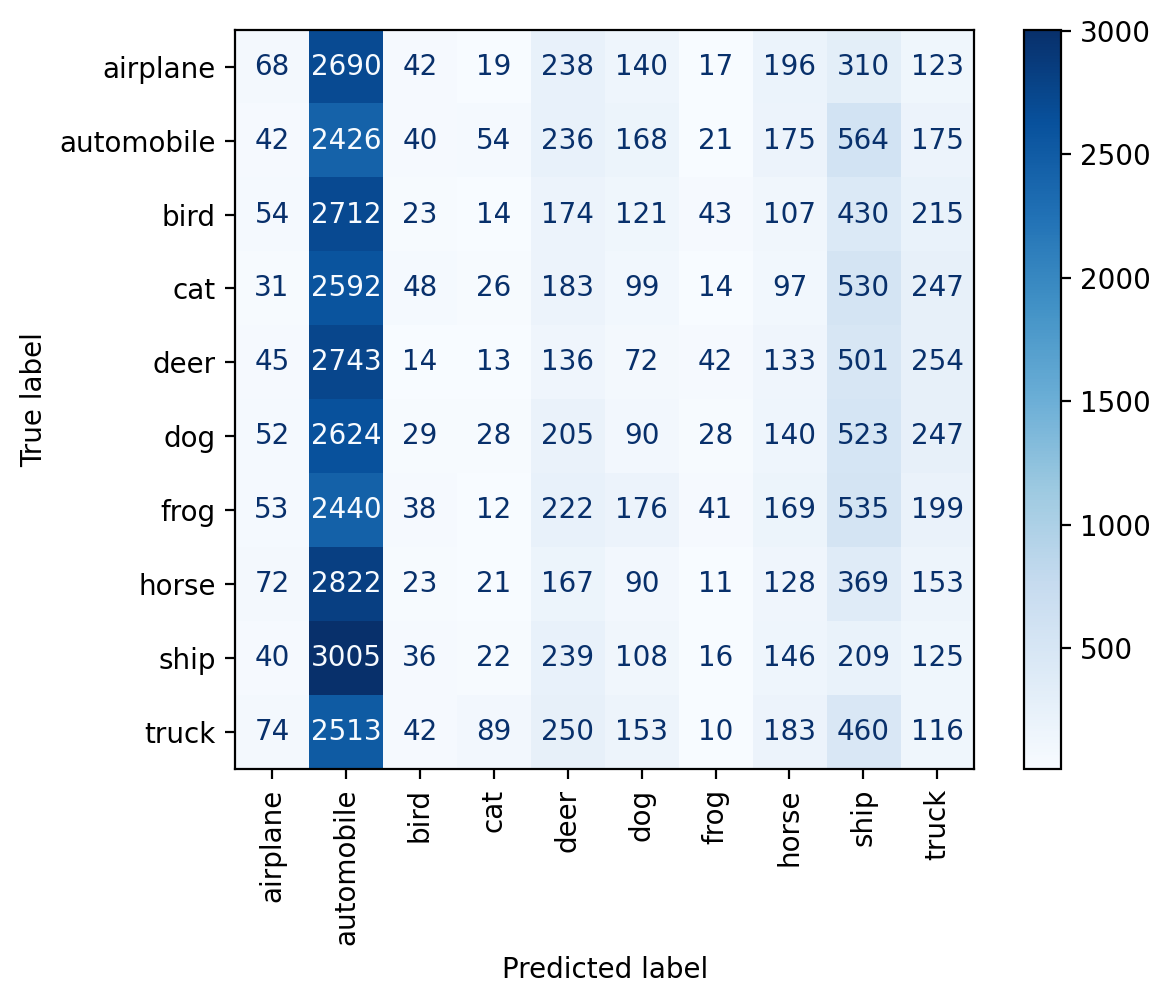

test set accuracy: 8.58%


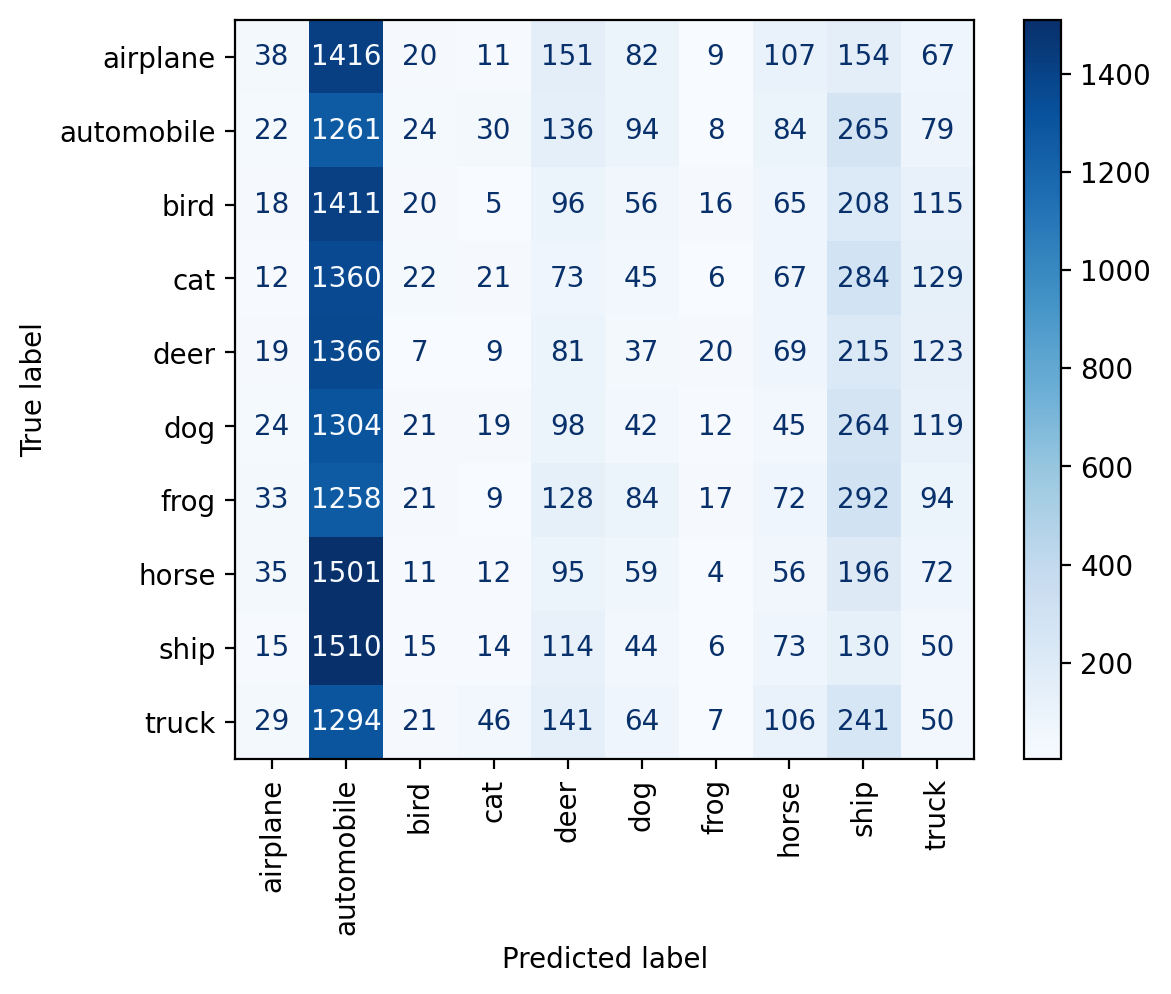

In [12]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()

predict(resnet, dataset.classes, plot_confusion_matrix=True)

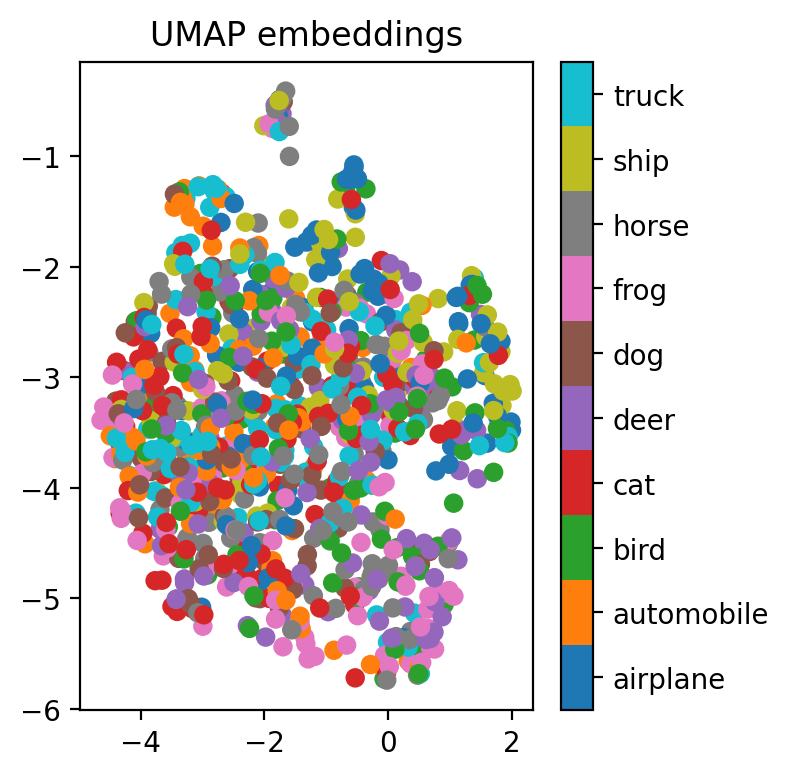

In [13]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

viz_embeddings(resnet, X[train_idx], y[train_idx], device)

#### Train the model on train set

In [20]:
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(resnet, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

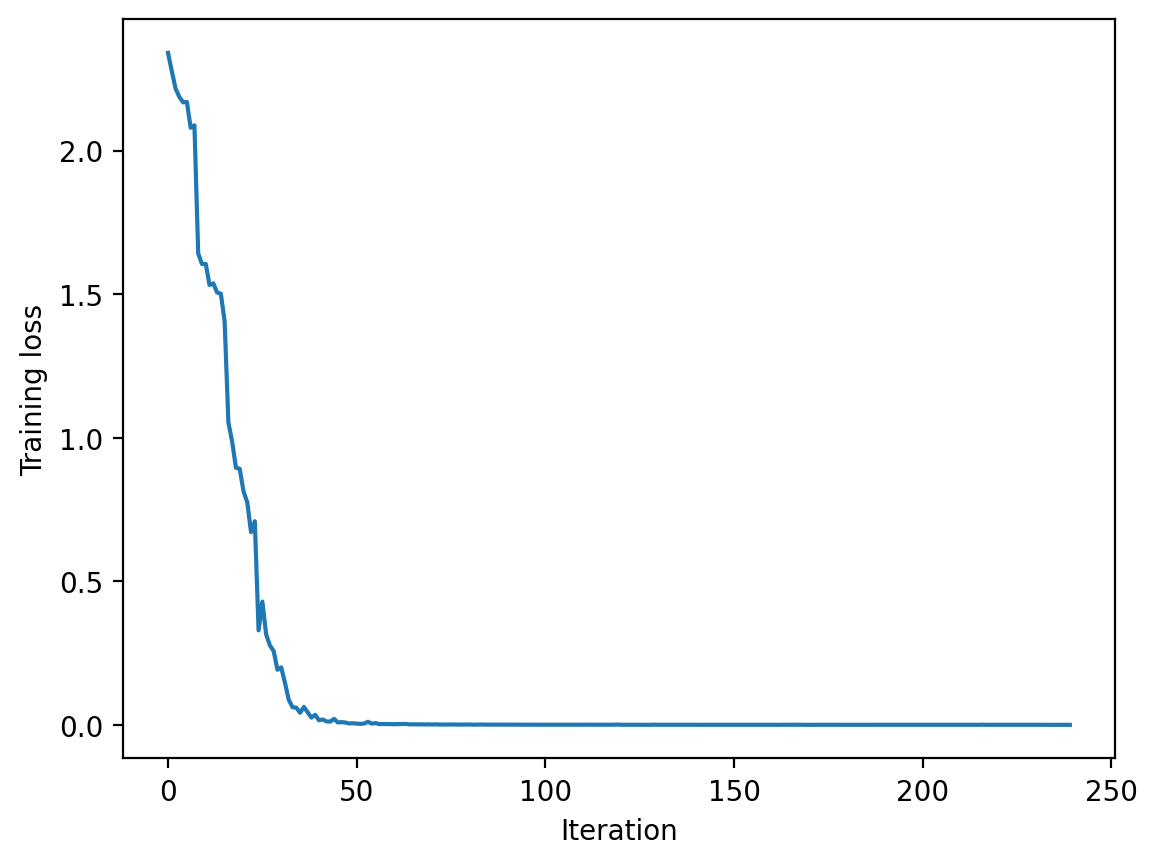

In [21]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


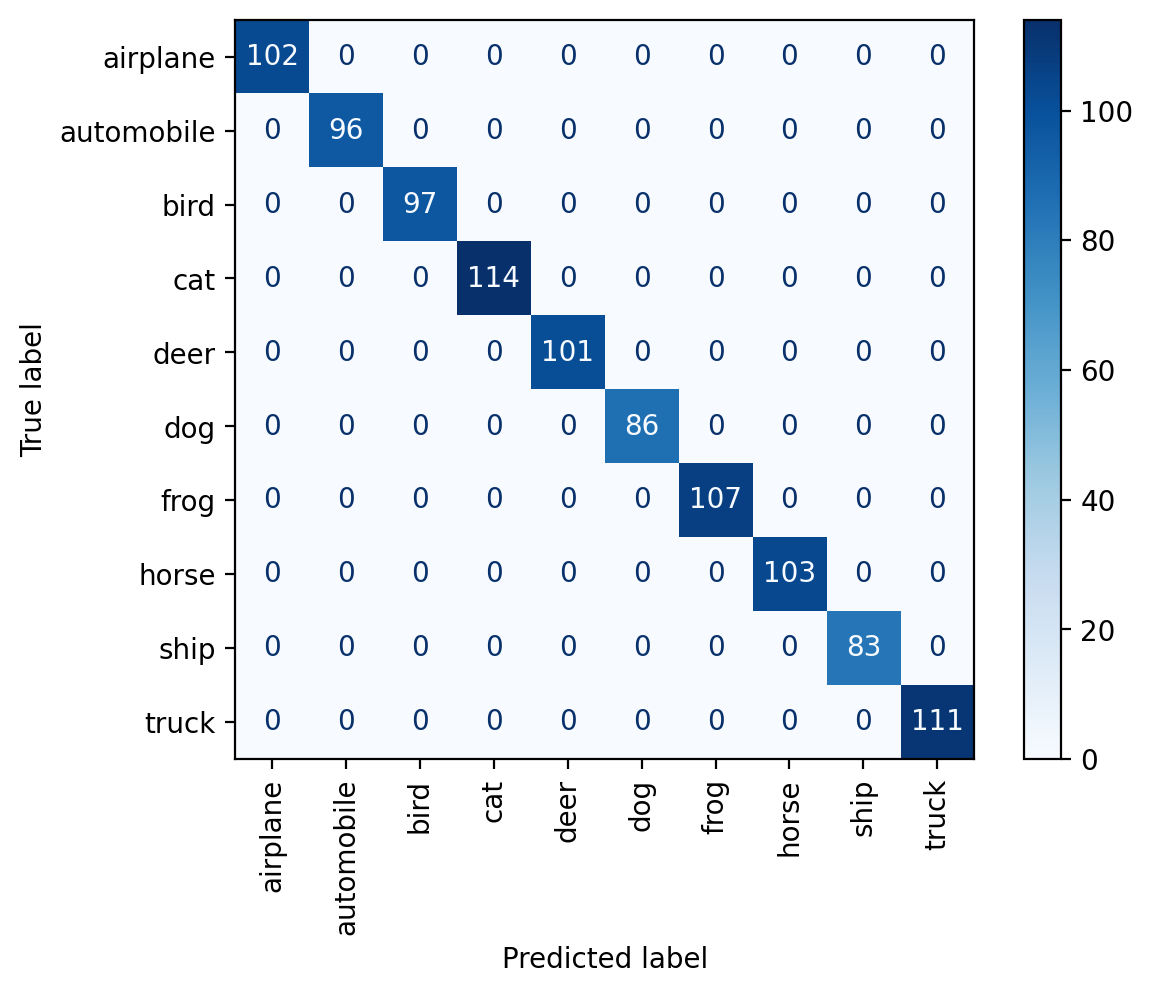

pool set accuracy: 36.02%


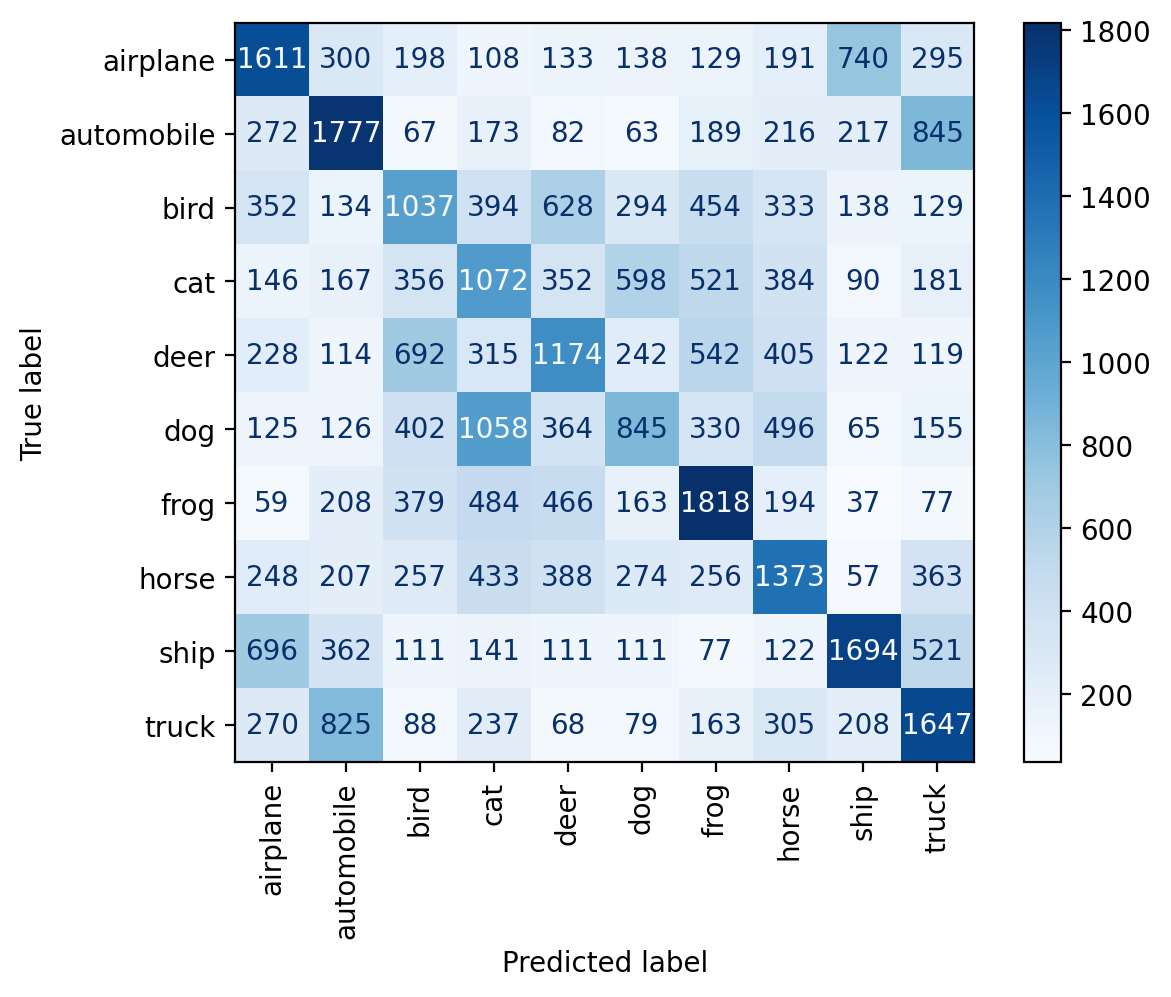

test set accuracy: 35.99%


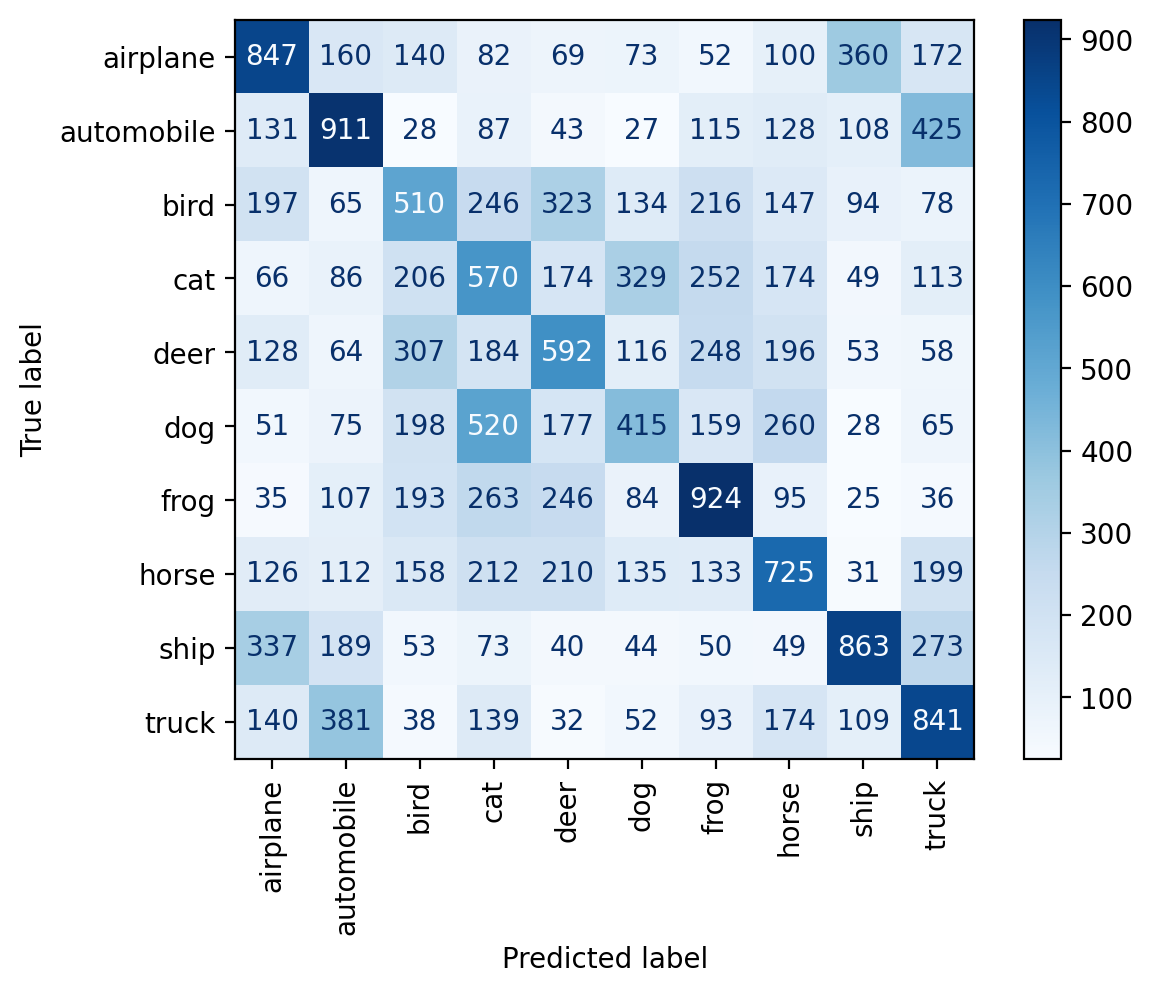

In [22]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


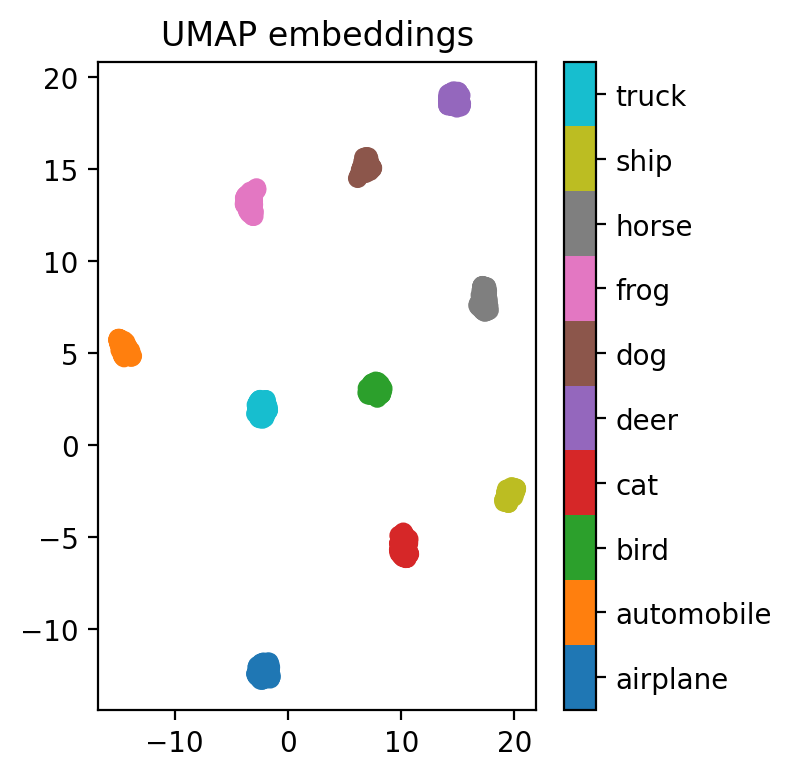

In [23]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

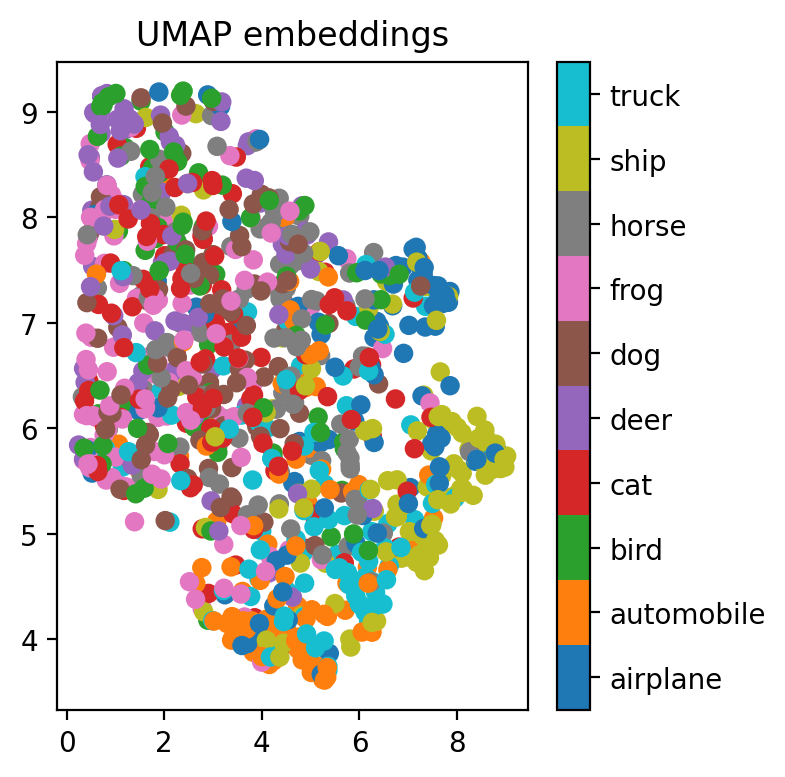

In [24]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

#### Train on train + pool

In [26]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

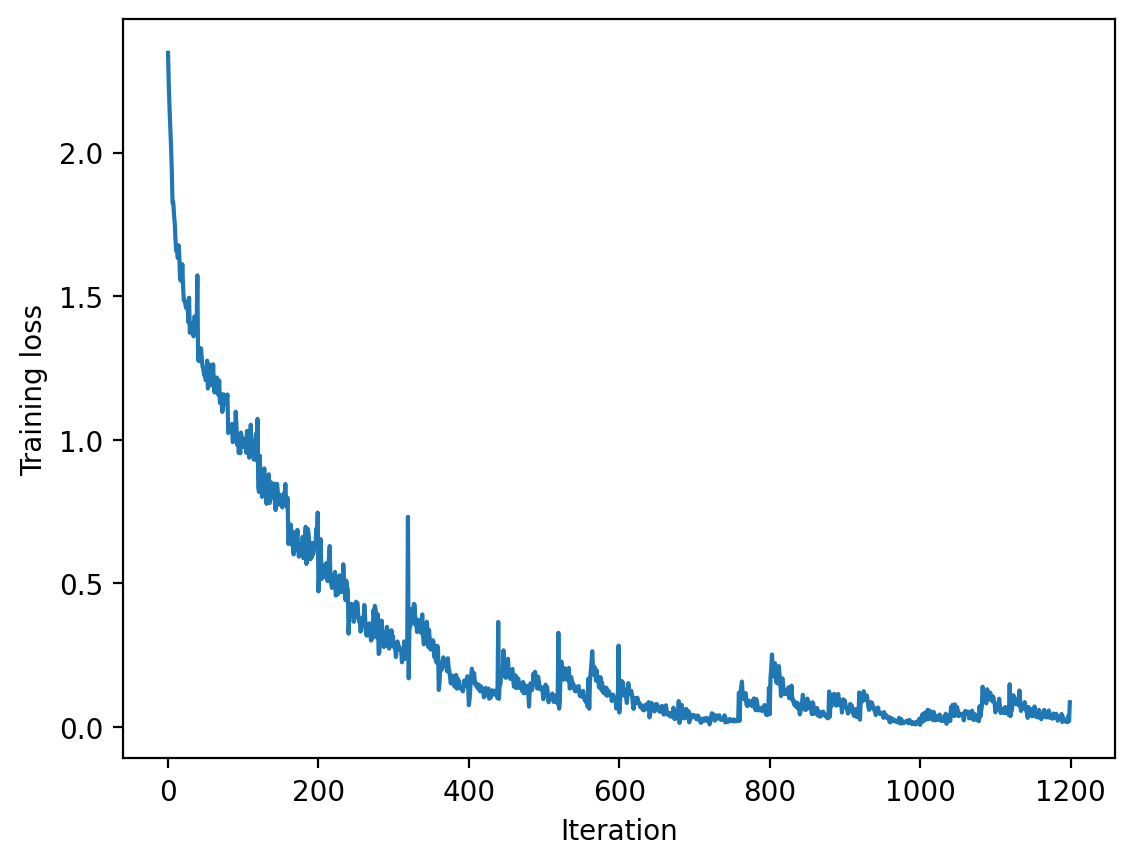

In [27]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss")

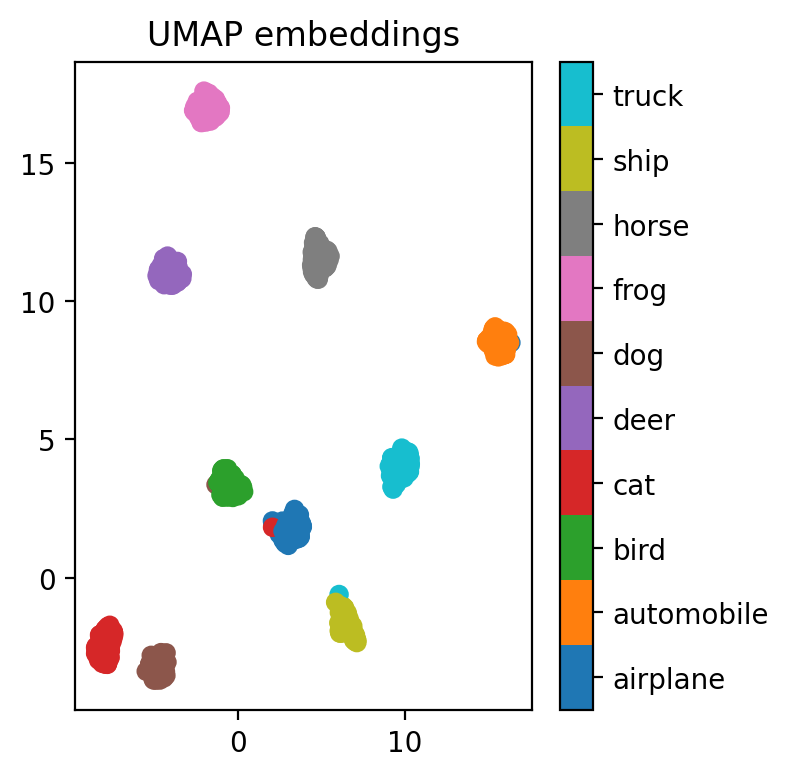

In [28]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

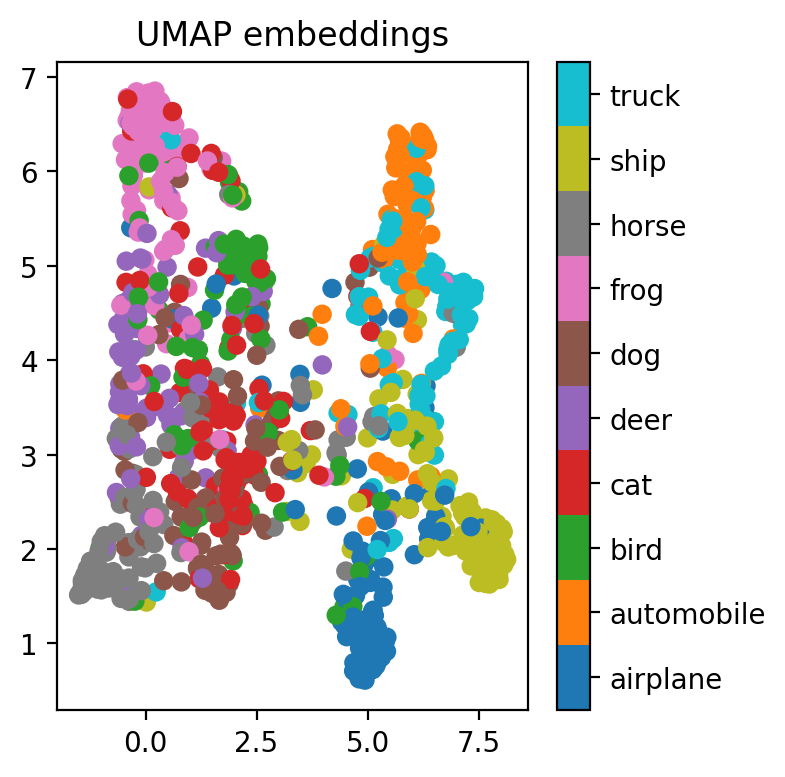

In [29]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.40%


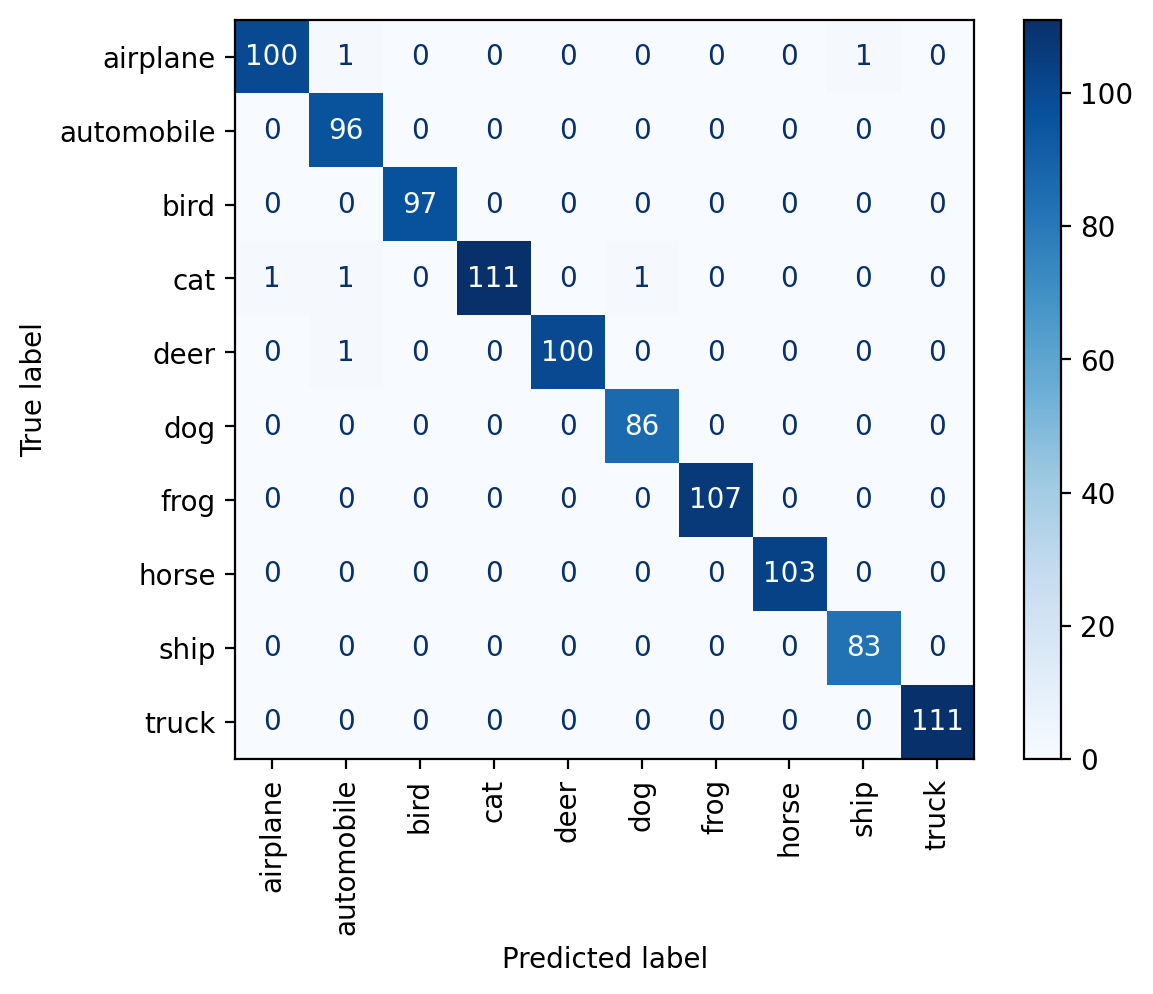

pool set accuracy: 99.56%


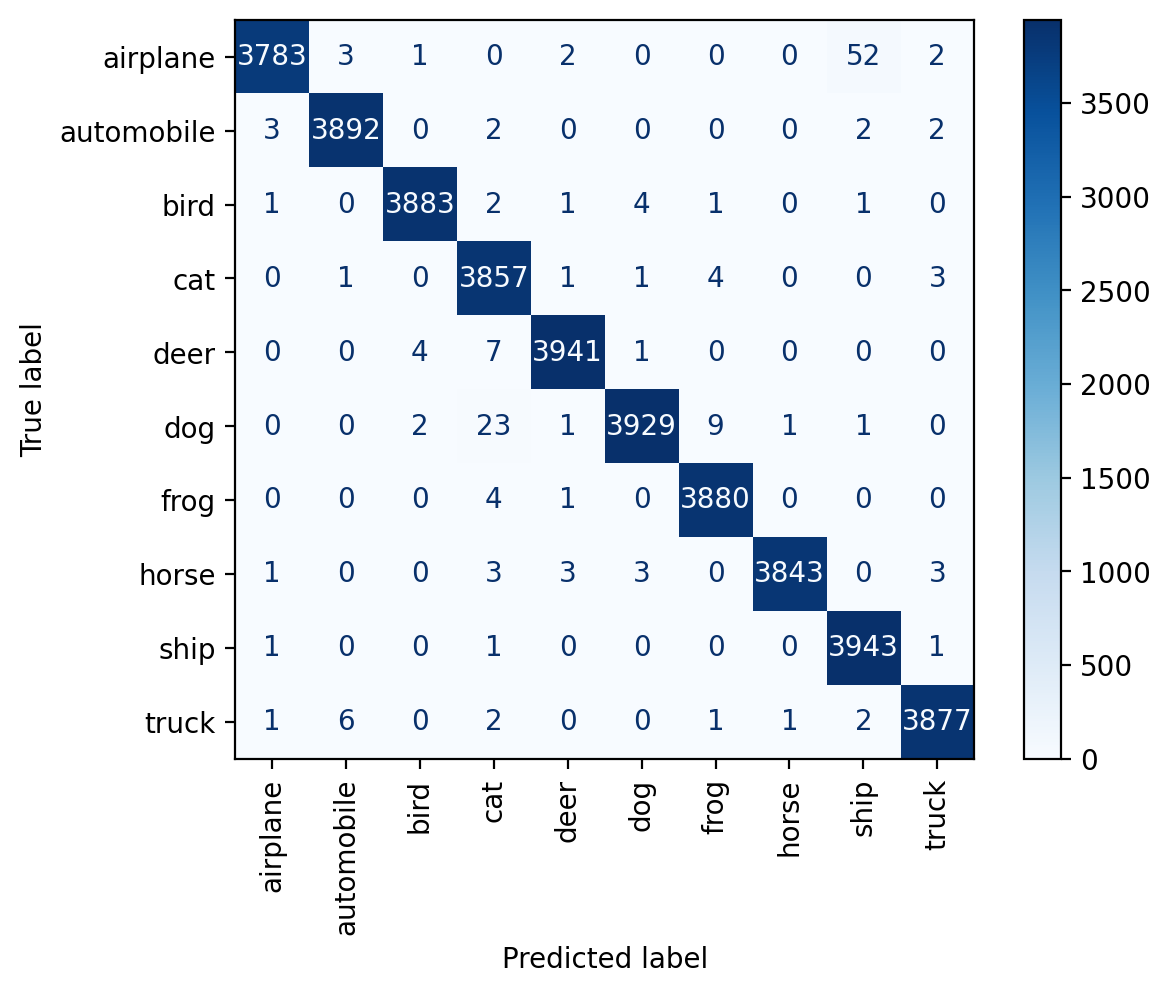

test set accuracy: 62.17%


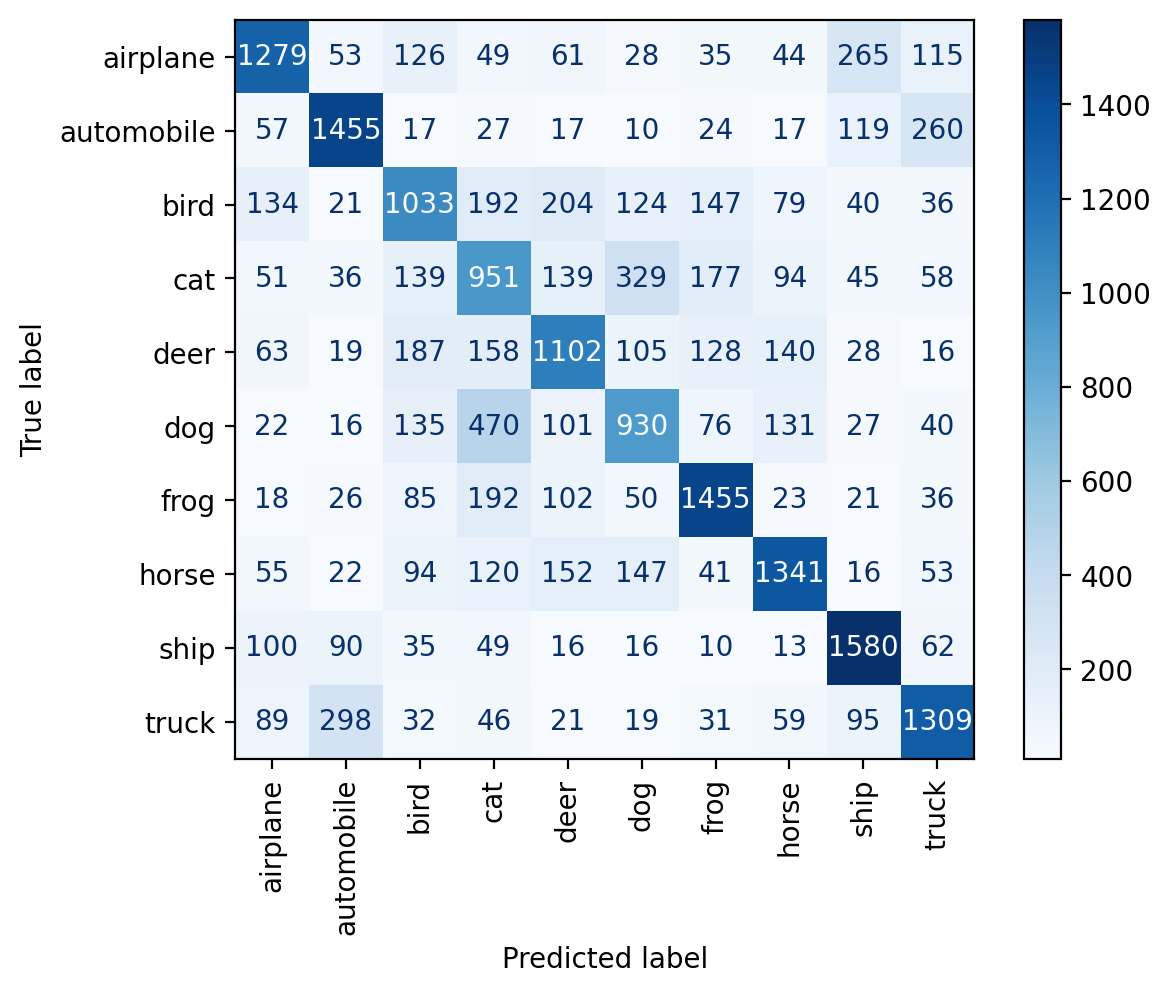

In [30]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

### SSL
#### Task 1: Predict angle of rotation (0, 90, 180, 270) as a classification task

Create a dataset with rotated images and corresponding labels. We can now use a much larger dataset



In [38]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [39]:
X_ssl = []
y_ssl = []

angles_map = {0:0, 90:1, 180:2, 270:3}
for angle_rot in angles_map.keys():
    print(f"Angle: {angle_rot}")
    X_rot = transforms.functional.rotate(X_train_plus_pool, angle_rot)
    X_ssl.append(X_rot)
    y_ssl.append(torch.tensor([angles_map[angle_rot]]*len(X_rot)))
    
X_ssl = torch.cat(X_ssl)
y_ssl = torch.cat(y_ssl)

Angle: 0
Angle: 90
Angle: 180
Angle: 270


In [40]:
X_ssl.shape, y_ssl.shape

(torch.Size([160000, 3, 32, 32]), torch.Size([160000]))

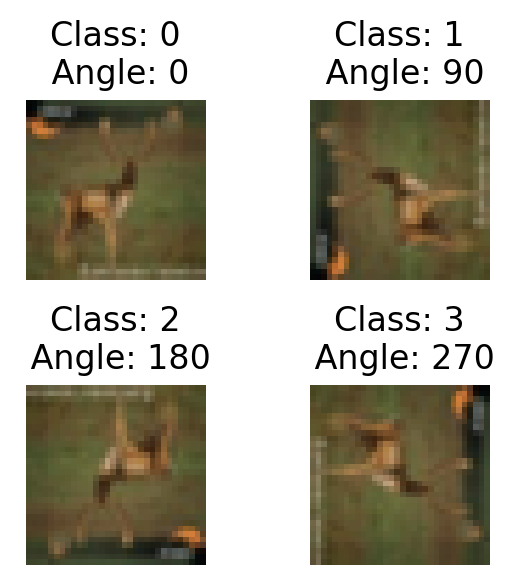

In [41]:
# Plot same image rotated at different angles
def plot_ssl(img_id):
    plt.figure(figsize=(3, 3))
    offset = len(X_train_plus_pool)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(torch.einsum("chw->hwc", X_ssl[offset*i + img_id]))
        plt.axis('off')
        plt.title(f"Class: {angles_map[i*90]}\n Angle: {i*90}")
    plt.tight_layout()
plot_ssl(2)

In [48]:
ssl_angle = ResNetClassifier(models.resnet18, None, n_classes=4, activation=nn.GELU(), dropout=0.1).to(device)

In [49]:
iter_losses, epoch_losses = train_fn(ssl_angle, X_ssl, y_ssl, lr=3e-4, loss_fn=nn.CrossEntropyLoss(),
                                        batch_size=1024, epochs=20)

Loss: 0.945101: 100%|██████████| 157/157 [00:04<00:00, 35.35it/s]


Epoch 1: 0.9923952384948731


Loss: 0.785275: 100%|██████████| 157/157 [00:04<00:00, 35.88it/s]


Epoch 2: 0.8178635284423829


Loss: 0.644941: 100%|██████████| 157/157 [00:04<00:00, 35.64it/s]


Epoch 3: 0.7248399837493896


Loss: 0.697314: 100%|██████████| 157/157 [00:04<00:00, 36.29it/s]


Epoch 4: 0.644944263458252


Loss: 0.578679: 100%|██████████| 157/157 [00:04<00:00, 35.66it/s]


Epoch 5: 0.5666926818847656


Loss: 0.478466: 100%|██████████| 157/157 [00:04<00:00, 36.11it/s]


Epoch 6: 0.4871123765945435


Loss: 0.466891: 100%|██████████| 157/157 [00:04<00:00, 35.93it/s]


Epoch 7: 0.4118640880584717


Loss: 0.436392: 100%|██████████| 157/157 [00:04<00:00, 35.65it/s]


Epoch 8: 0.3425796222686768


Loss: 0.302828: 100%|██████████| 157/157 [00:04<00:00, 36.11it/s]


Epoch 9: 0.2795945789337158


Loss: 0.226936: 100%|██████████| 157/157 [00:04<00:00, 35.73it/s]


Epoch 10: 0.2271963834762573


Loss: 0.260345: 100%|██████████| 157/157 [00:04<00:00, 35.70it/s]


Epoch 11: 0.18415976438522338


Loss: 0.136557: 100%|██████████| 157/157 [00:04<00:00, 36.13it/s]


Epoch 12: 0.15323887557983398


Loss: 0.214188: 100%|██████████| 157/157 [00:04<00:00, 35.74it/s]


Epoch 13: 0.13012397813796997


Loss: 0.114707: 100%|██████████| 157/157 [00:04<00:00, 35.61it/s]


Epoch 14: 0.10969336915016174


Loss: 0.100094: 100%|██████████| 157/157 [00:04<00:00, 35.93it/s]


Epoch 15: 0.09902867212295532


Loss: 0.114667: 100%|██████████| 157/157 [00:04<00:00, 36.11it/s]


Epoch 16: 0.08491913187503815


Loss: 0.088765: 100%|██████████| 157/157 [00:04<00:00, 36.15it/s]


Epoch 17: 0.07862492105960846


Loss: 0.094059: 100%|██████████| 157/157 [00:04<00:00, 36.16it/s]


Epoch 18: 0.0721992644071579


Loss: 0.135386: 100%|██████████| 157/157 [00:04<00:00, 34.21it/s]


Epoch 19: 0.068406194627285


Loss: 0.073386: 100%|██████████| 157/157 [00:04<00:00, 35.75it/s]


Epoch 20: 0.061716662764549256


Text(0, 0.5, 'Training loss')

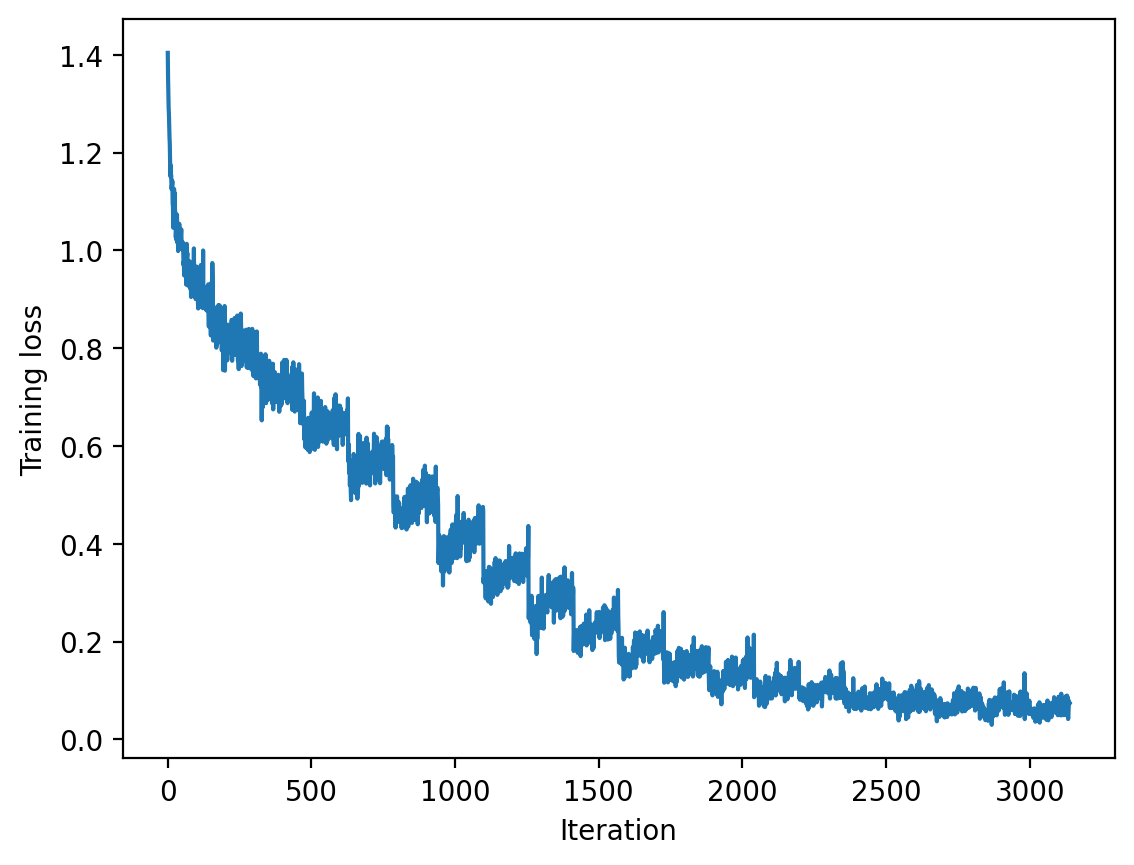

In [50]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

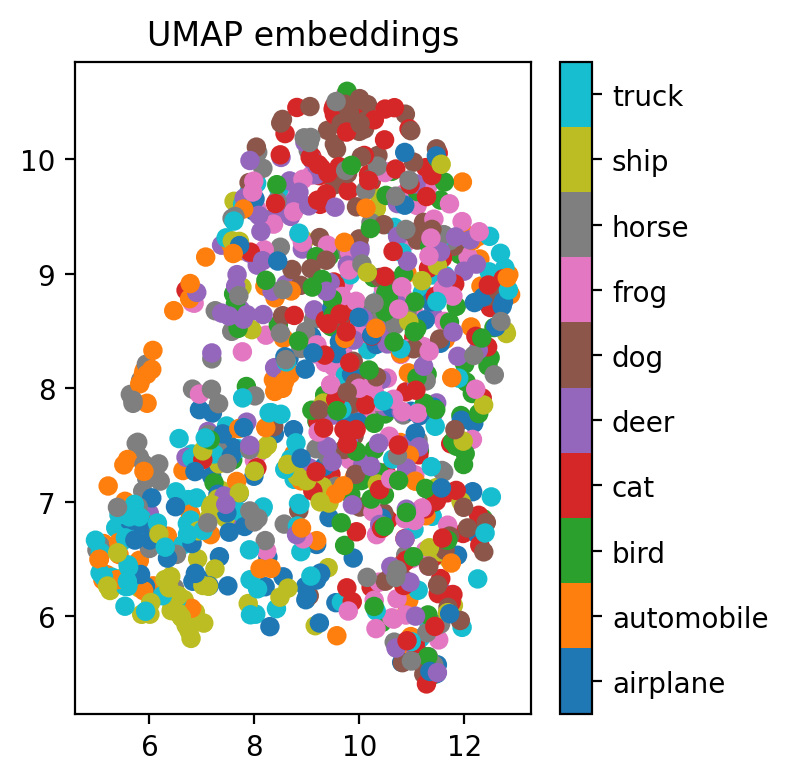

In [51]:
# Visualise the embeddings of the SSL model trained on angles dataset 
# (but wrt original 10 classes)
viz_embeddings(ssl_angle, X[train_idx], y[train_idx], device)

In [52]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
net_pretrained.featurizer.load_state_dict(ssl_angle.featurizer.state_dict())

iter_losses, epoch_losses = train_fn(net_pretrained, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, epochs=50, batch_size=128, verbose=False)

Text(0, 0.5, 'Training loss')

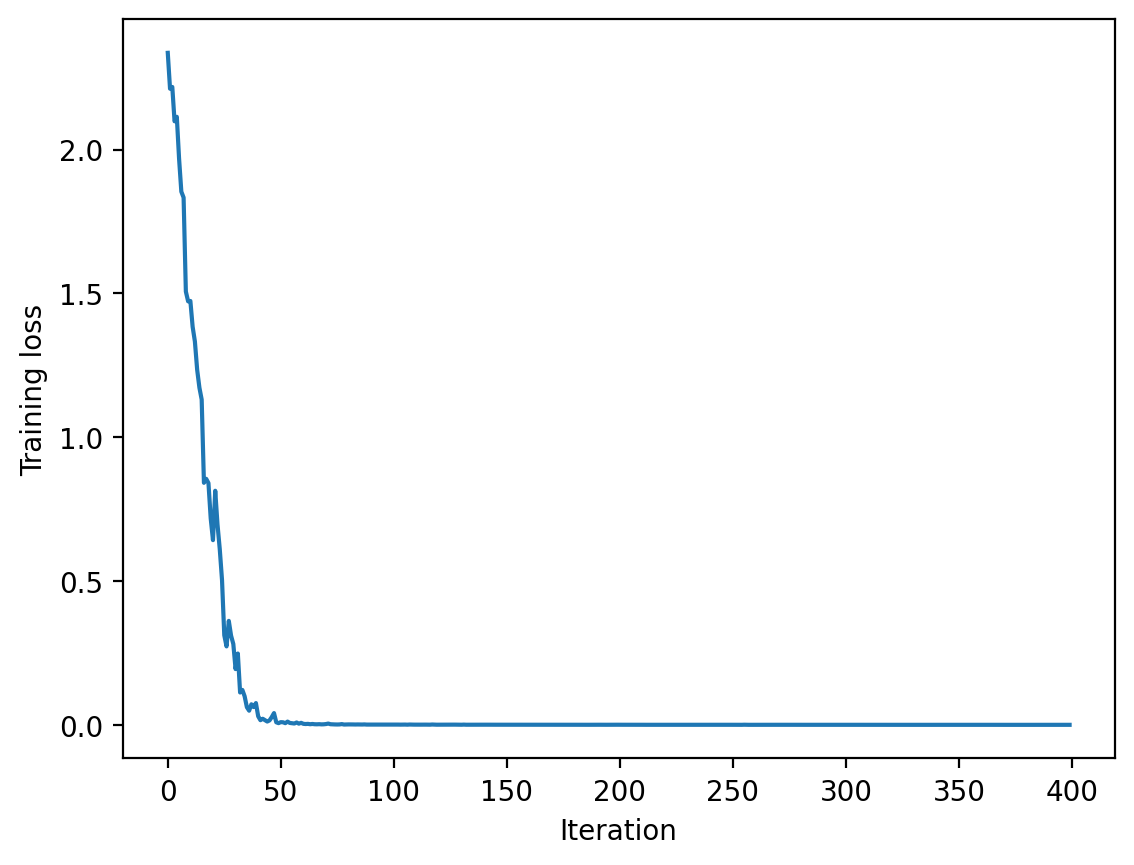

In [53]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


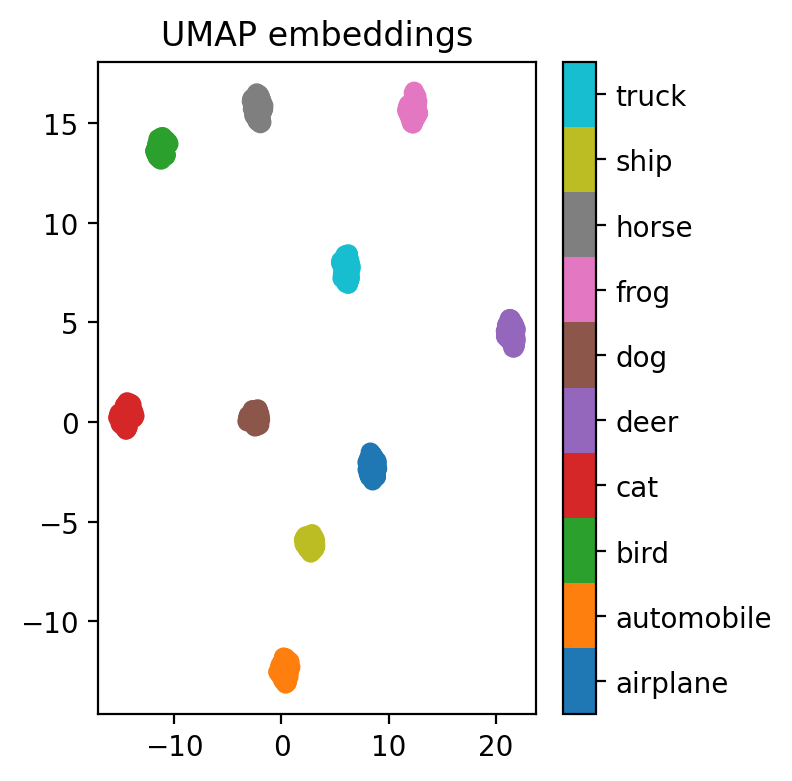

In [54]:
viz_embeddings(net_pretrained, X[train_idx], y[train_idx], device)

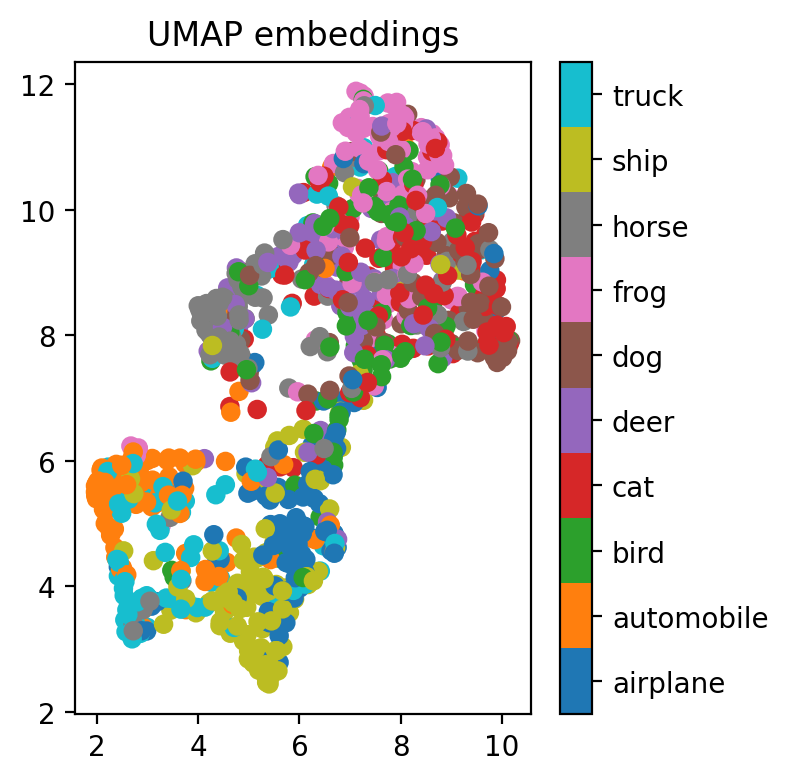

In [55]:
viz_embeddings(net_pretrained, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 100.00%


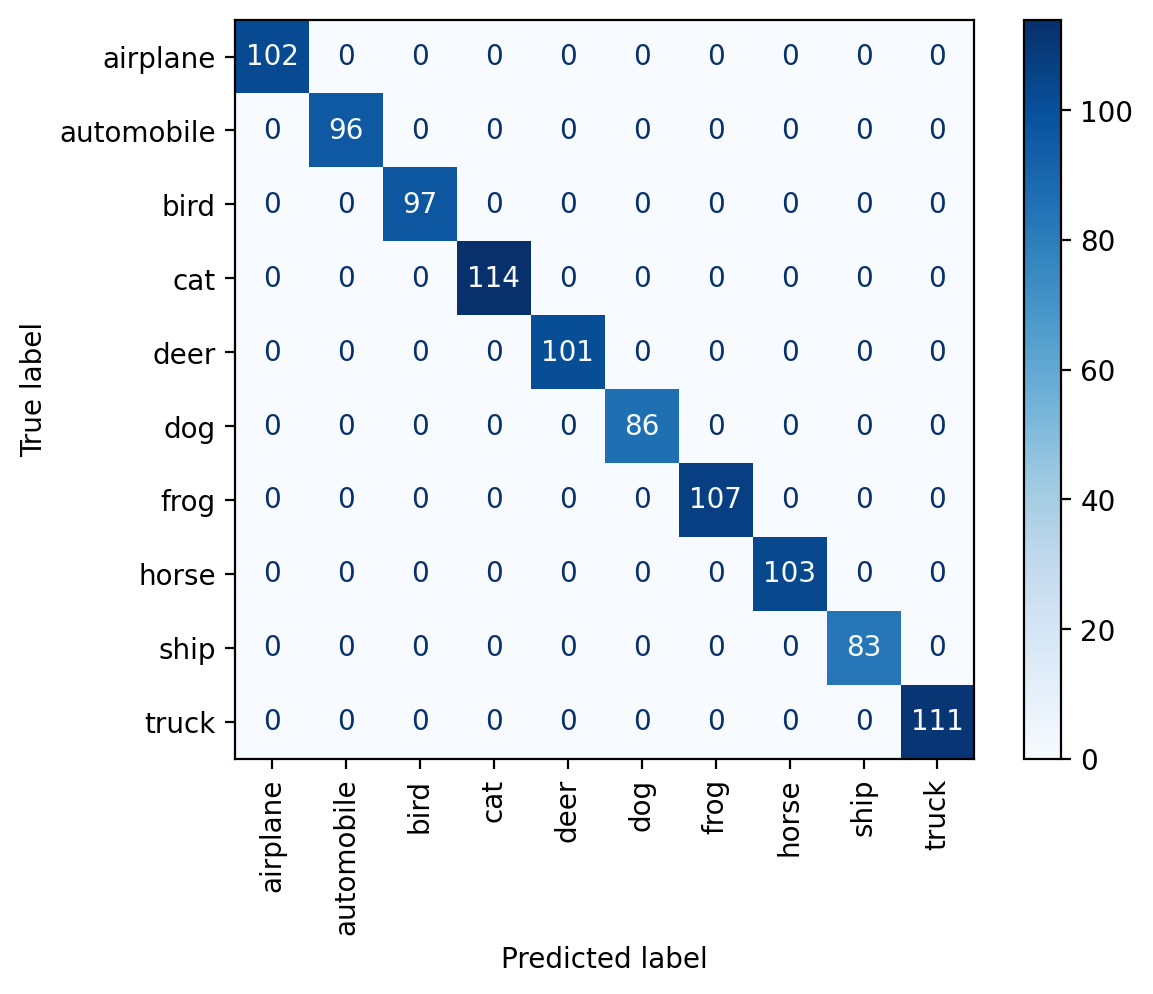

pool set accuracy: 47.94%


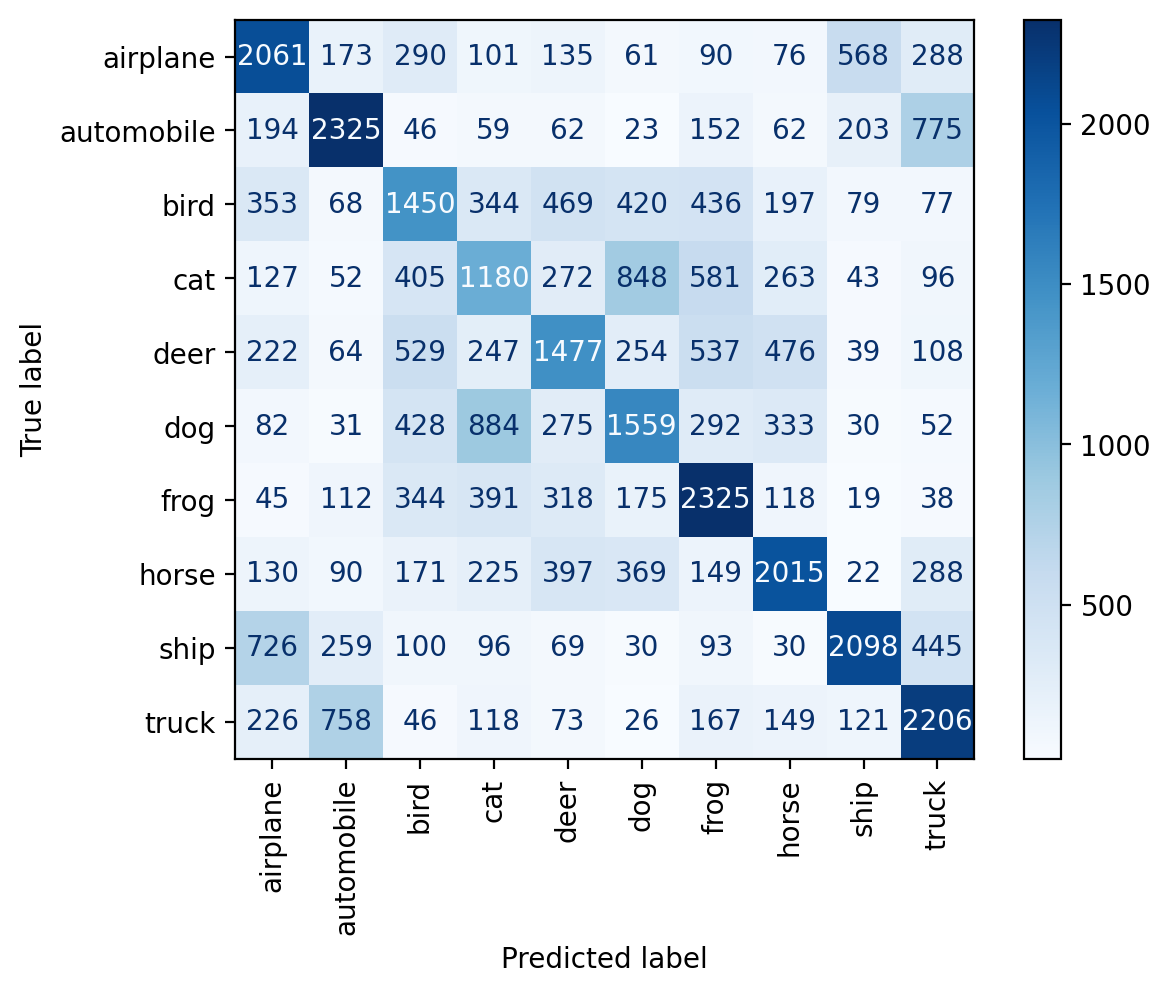

test set accuracy: 47.57%


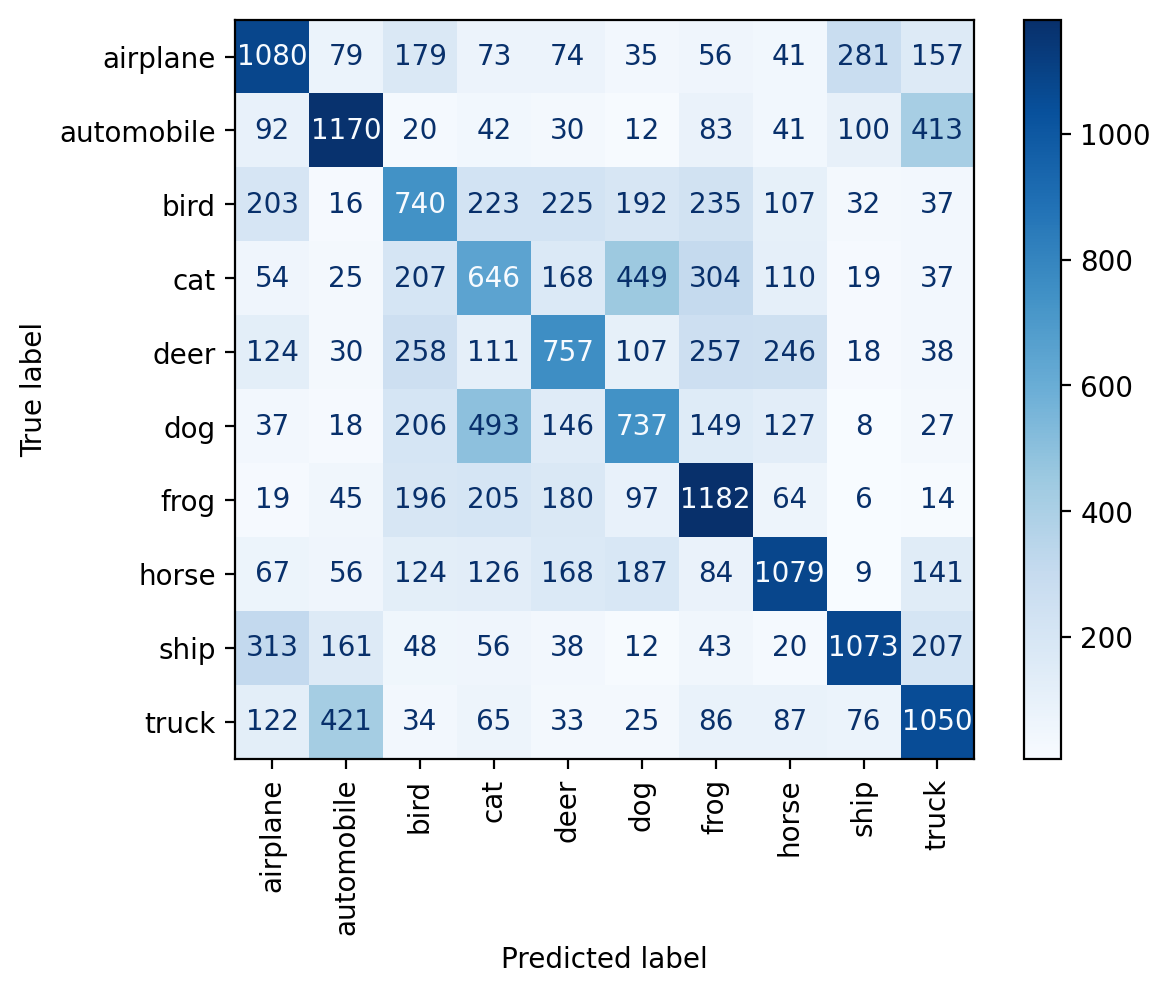

In [56]:
predict(net_pretrained, dataset.classes, plot_confusion_matrix=True)

### Summary of the test set performance

- Untrained model: 9%
- Train on 1000 labeled samples (train set): 36%
- Train on 1000 labeled samples + 39000 label samples (pool set): 62%
- Train on SSL task + Finetune on 1000 labeled samples: 47%